In [25]:
import os
print(os.getcwd())


C:\Users\mahmoody\Desktop\gait_project\notebooks


In [29]:
import numpy as np
import pandas as pd
fs = 100
time = np.arange(0 , 10 , 1/fs)

right_z = 0.02 * np.sin(2 * np.pi * time * 1.2) + 0.01
left_z = 0.02 * np.sin(2 * np.pi * time * 1.2 + np.pi) + 0.01

right_z += np.random.normal(0 , 0.002 , len(time))
left_z += np.random.normal(0 , 0.002 , len(time))

df = pd.DataFrame({
    "time" : time,
    "foot_right_z_m" : right_z,
    "foot_left_z_m" : left_z
})

df.to_csv("../data/synthetic_gait.csv", index = False)
print("done")
df.head()

done


,time,foot_right_z_m,foot_left_z_m
0,0.00,0.006937,0.011126
1,0.01,0.014280,0.007939
2,0.02,0.014253,0.006329
3,0.03,0.010693,0.003179
4,0.04,0.018410,0.002936


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv("../data/synthetic_gait.csv")
df.head()

,time,foot_right_z_m,foot_left_z_m
0,0.00,0.006937,0.011126
1,0.01,0.014280,0.007939
2,0.02,0.014253,0.006329
3,0.03,0.010693,0.003179
4,0.04,0.018410,0.002936


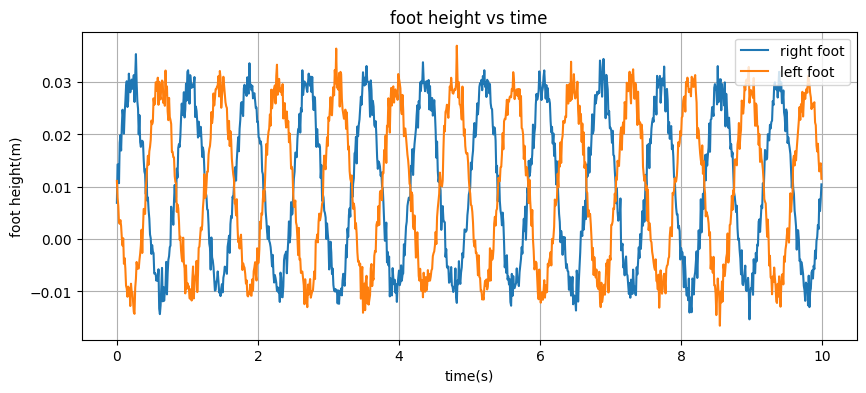

In [37]:
time = df["time"].values
right_z = df["foot_right_z_m"].values
left_z = df["foot_left_z_m"].values

plt.figure(figsize = (10,4))
plt.plot(time ,right_z ,label = "right foot")
plt.plot(time ,left_z , label = "left foot")

plt.xlabel("time(s)")
plt.ylabel("foot height(m)")
plt.title("foot height vs time")
plt.legend()
plt.grid(True)

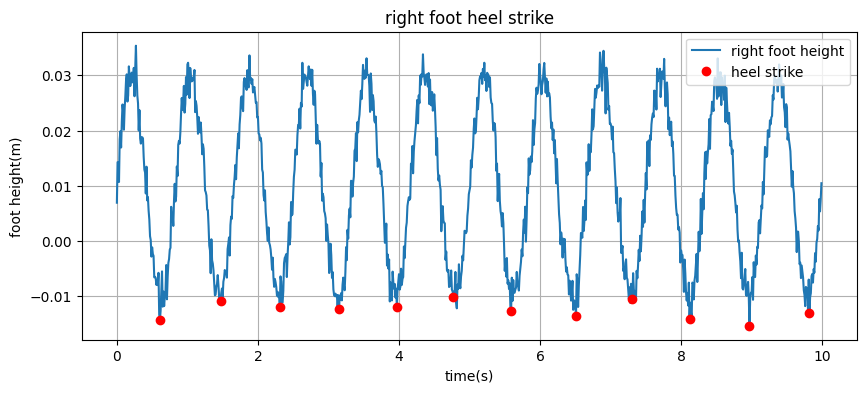

In [39]:
from scipy.signal import find_peaks

inverted_right = -right_z

peaks, _ = find_peaks(inverted_right , distance = 80)
plt.figure(figsize = (10,4))
plt.plot(time ,right_z ,label = "right foot height")
plt.plot(time[peaks] ,right_z[peaks] ,"ro" ,label = "heel strike")
plt.xlabel("time(s)")
plt.ylabel("foot height(m)")
plt.title("right foot heel strike")
plt.legend()
plt.grid(True)
plt.show()

right hs times: [0.61 1.47 2.31 3.15 3.97 4.77 5.59 6.51 7.31 8.12 8.97 9.82]
left hs times: [0.25 1.06 1.86 2.66 3.49 4.34 5.2  6.01 6.86 7.69 8.55 9.41]


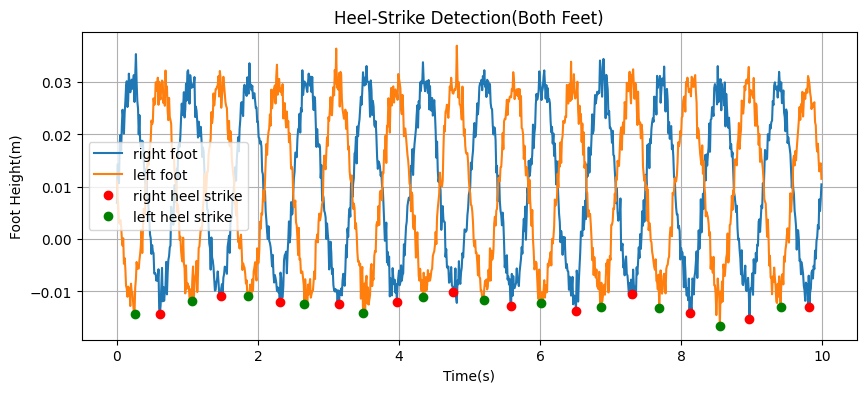

In [47]:
peaks_r, _ = find_peaks(-right_z , distance = 80)
hs_t_r = time[peaks_r]

peaks_l, _ = find_peaks(-left_z , distance = 80)
hs_t_l = time[peaks_l] 

print("right hs times:" , np.round(hs_t_r,3))
print("left hs times:" , np.round(hs_t_l,3))

plt.figure(figsize = (10,4))
plt.plot(time, right_z, label = "right foot")
plt.plot(time, left_z, label = "left foot")
plt.plot(hs_t_r ,right_z[peaks_r], "ro" , label = "right heel strike")
plt.plot(hs_t_l, left_z[peaks_l] , "go" , label = "left heel strike")
plt.xlabel("Time(s)")
plt.ylabel("Foot Height(m)")
plt.title("Heel-Strike Detection(Both Feet)")
plt.legend()
plt.grid(True)
plt.show()